In [16]:
import torch
from scipy.ndimage import center_of_mass, shift
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

#-----------------------------------------------------------------------评测指标--------------------------------------------------------------
def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1[:, :, i], img2[:, :, i]))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

def move2cpu(d):
    """Move data from gpu to cpu"""
    return d.detach().cpu().float().numpy()

def tensor2im01(im_t):
    """Copy the tensor to the cpu & convert to range [0,255]"""
    im_np = np.clip(np.round((np.transpose(move2cpu(im_t).squeeze(0), (1, 2, 0))) * 255.0), 0, 255)
    return im_np.astype(np.uint8)

def calculate_psnr(img1, img2, is_kernel=False):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse)) if is_kernel else 20 * math.log10(255.0 / math.sqrt(mse))


def evaluation_image(hr, sr, sf):

    hr = tensor2im01(hr)
    sr = tensor2im01(sr)
    hr = rgb2ycbcr(hr / 255., only_y=True)
    sr = rgb2ycbcr(sr / 255., only_y=True)
    crop_border = sf**2
    cropped_sr = sr[crop_border:-crop_border, crop_border:-crop_border]
    hr_11 = (hr.shape[0]-cropped_sr.shape[0])//2
    hr_12 = hr.shape[0] - cropped_sr.shape[0] - hr_11
    hr_21 = (hr.shape[1] - cropped_sr.shape[1]) // 2
    hr_22 = hr.shape[1] - cropped_sr.shape[1] - hr_21
    cropped_hr = hr[hr_11:-hr_12, hr_21:-hr_22]
    im_psnr = calculate_psnr(cropped_hr * 255, cropped_sr * 255)
    im_ssim = calculate_ssim(cropped_hr * 255, cropped_sr * 255)

    return im_psnr, im_ssim


def gen_kernel_fixed(k_s, scale_factor, lambda_1, lambda_2, theta, noise, move_x, move_y):
    k_size = (np.ones(2, dtype=int) * int(k_s))
    # Set COV matrix using Lambdas and Theta
    LAMBDA = np.diag([lambda_1, lambda_2]);
    Q = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    SIGMA = Q @ LAMBDA @ Q.T
    INV_SIGMA = np.linalg.inv(SIGMA)[None, None, :, :]

    # Set expectation position (shifting kernel for aligned image)
    MU = k_size // 2 + 0.5 * (scale_factor - k_size % 2)
    MU = MU[None, None, :, None]

    # Create meshgrid for Gaussian
    [X, Y] = np.meshgrid(range(k_size[0]), range(k_size[1]))
    Z = np.stack([X, Y], 2)[:, :, :, None]

    # Calcualte Gaussian for every pixel of the kernel
    ZZ = Z - MU
    ZZ_t = ZZ.transpose(0, 1, 3, 2)
    raw_kernel = np.exp(-0.5 * np.squeeze(ZZ_t @ INV_SIGMA @ ZZ)) * (1 + noise)

    # shift the kernel so it will be centered
    raw_kernel_moved = kernel_move(raw_kernel, move_x, move_y)

    # Normalize the kernel and return
    kernel = raw_kernel_moved / np.sum(raw_kernel_moved)
    # kernel = raw_kernel_centered / np.sum(raw_kernel_centered)

    return kernel

def kernel_move(kernel, move_x, move_y):
    # First calculate the current center of mass for the kernel
    current_center_of_mass = center_of_mass(kernel)   #寻找中心值

    current_center_of_mass_list = list(current_center_of_mass)
    shift_vec_list = list(current_center_of_mass)

    # Define the shift vector for the kernel shifting (x,y)
    shift_vec_list[0] = move_x - current_center_of_mass_list[0]
    shift_vec_list[1] = move_y - current_center_of_mass_list[1]

    shift_vec = tuple(shift_vec_list)

    # Finally shift the kernel and returnsqueeze().detach().cpu()
    return shift(kernel, shift_vec)    #kernel的平移

def gen_kernel_random():
    kernel_size = 19
    sf = 4
    lambda_1 = 3
    lambda_2 = 3
    theta = 0
    noise_level = 0
    noise = -noise_level + np.random.rand(kernel_size) * noise_level * 2
    move_x = kernel_size/2 # self.kernel_size / 2 - 1
    move_y = move_x
    kernel = gen_kernel_fixed(kernel_size, sf, lambda_1, lambda_2, theta, noise, move_x, move_y)

    return torch.from_numpy(kernel).type(torch.FloatTensor).to(torch.device('cuda')).unsqueeze(0).unsqueeze(0)

def show_image(tensor):
    # 将Tensor转换回图片格式，使用permute将通道移到最后
    tensor = tensor.squeeze(0).detach().cpu() # [B, C, H, W] -> [C, H, W]
    image = tensor.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    plt.imshow(image)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

def add_blur(X, K):
    kernel_size = K.shape[-1]
    # 图像预处理
    X_pad = F.pad(X, mode='circular',
                   pad=(kernel_size // 2, kernel_size // 2, kernel_size // 2,
                        kernel_size // 2))

    # k = kernel.expand(3, -1, -1, -1).clone().detach()
    out_x = F.conv2d(X_pad, kernel.expand(3, -1, -1, -1).clone().detach(), groups=3)
    # out_x = Move_X_forward(out_x, move_x=1)

    return out_x

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 读取图片
image_path = "data/datasets/Set5/HR/ISAR1.png"  # 图片的本地路径
image = Image.open(image_path)  # 使用PIL打开图片

# 图像预处理（如调整大小、转换为tensor）
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整图像大小
    transforms.ToTensor()           # 转换为Tensor，值归一化到[0,1]范围
])

# 应用预处理并将图像转换为Tensor
image_tensor = transform(image)

# 添加 batch 维度 (PyTorch的模型通常期望输入为 [batch_size, channels, height, width])
HR_img = image_tensor.unsqueeze(0).to(device)

if HR_img.shape[1] == 4:
    HR_img = HR_img[:,0:3,:,:]

# 生成模糊核
kernel = gen_kernel_random().to(device)

# 得到模糊图像
blur_img = add_blur(HR_img, kernel)


# #打印生成的清晰图像、模糊图像和模糊核
# show_image(HR_img)
# show_image(blur_img)
# show_image(kernel)
#-------------------------------------------------------------------------------------------ADMM-------------------------------------
RGB_blur = blur_img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
# TV损失函数python实现
def TVLoss(x):
    h_x = x.size()[2]
    w_x = x.size()[3]
    h_tv = torch.pow(x[:,:,1:, :] - x[:,:,:h_x-1, :], 2).sum()
    w_tv = torch.pow(x[:,:,:, 1:] - x[ :,:,:, :w_x-1], 2).sum()
    count_h = x[:,:,:,1:].size()[2]*x[:,:,:,1:].size()[3]
    count_w = x[:,:,1:,:].size()[2]*x[:,:,1:,:].size()[3]
    return 2 * (h_tv / count_h + w_tv / count_w)
# L2正则化项的闭合解表达
def update_z_l2(X, MU, lam, rho):
    # 根据解析解直接更新 z
    Z = (rho * (X + MU /rho)) / (2*lam + rho)
    return Z
# L1正则项的软阈值函数表达
def soft_thresholding(X, threshold):
    return torch.sign(X) * torch.maximum(torch.abs(X) - threshold, torch.tensor(0.0))

In [17]:
# ADMM参数设置
def admm_convolution_RGB(y, K, lam, rho, num_iters=300,option="L1"):
    # 初始化变量
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 保证输入为 torch 张量并搬运到对应设备
    y = torch.from_numpy(np.transpose(y,(2,0,1))).unsqueeze(0).to(device)
    X = torch.zeros_like(y).to(device)
    Z = torch.zeros_like(y).to(device)
    MU = torch.zeros_like(y).to(device)
    if option=="TV":
    #--------使用梯度下降方法进行求解z
        Z = torch.zeros_like(y, requires_grad=True).to(device)
        optimizer = torch.optim.Adam([Z], lr=0.01)
    #--------使用梯度下降方法进行求解z
    # 傅里叶变换卷积核
    # 卷积核 K 的傅里叶变换
    K = torch.from_numpy(K).unsqueeze(0).unsqueeze(0).to(device)
    K_fft = torch.fft.fft2(K, s=(y.shape)[2:4])
    K_fft_conj = torch.conj(K_fft)
    loss_values = []
    Y_fft = torch.fft.fft2(y)
    for i in range(num_iters):
        # Step 1: X更新 (通过FFT求解带卷积的优化问题)
        # 关于变量x的频域闭合解实现
        B = Z-MU / rho
        numerator = K_fft_conj * Y_fft + rho * torch.fft.fft2(B)
        denominator = K_fft_conj * K_fft + rho
        X_fft = numerator / denominator
        X = torch.real(torch.fft.ifft2(X_fft))

        # 关于使用梯度下将方法的变量z更新
        if option=="TV":
            optimizer.zero_grad()  # 清除之前的梯度
            tv_loss = lam * TVLoss(Z)  # TV正则化项
            fidelity_loss = (rho / 2) * torch.norm(X - Z + MU / rho) ** 2  # 保真项
            loss = fidelity_loss + tv_loss  # 总的损失函数
            # print(loss.item())
            loss.backward(retain_graph=True)  # 反向传播计算梯度
            optimizer.step()  # 更新Z
            loss.backward(retain_graph=True)  # 反向传播计算梯度
            optimizer.step()  # 更新Z
            loss_values.append(loss.item())
        elif option=="L1":
        # 关于使用梯度下将方法的变量z更新
            Z= soft_thresholding(X + MU / rho, lam / rho) #L1范数软阈值
        else:
            Z = update_z_l2(X, MU, lam, rho) # L2正则项
        # Step 3: U更新 (拉格朗日乘子更新)
        MU = MU + rho * (X - Z)
    if option=="TV":
        plt.plot(loss_values)
        plt.title('Loss Curve')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
    return X.detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


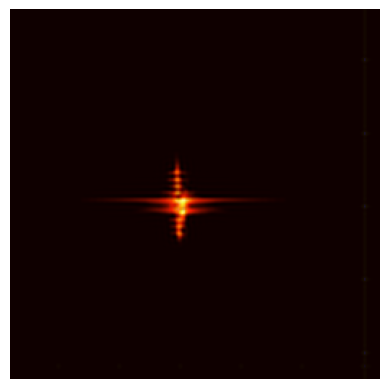

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


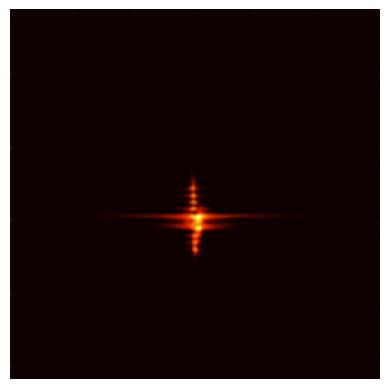

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


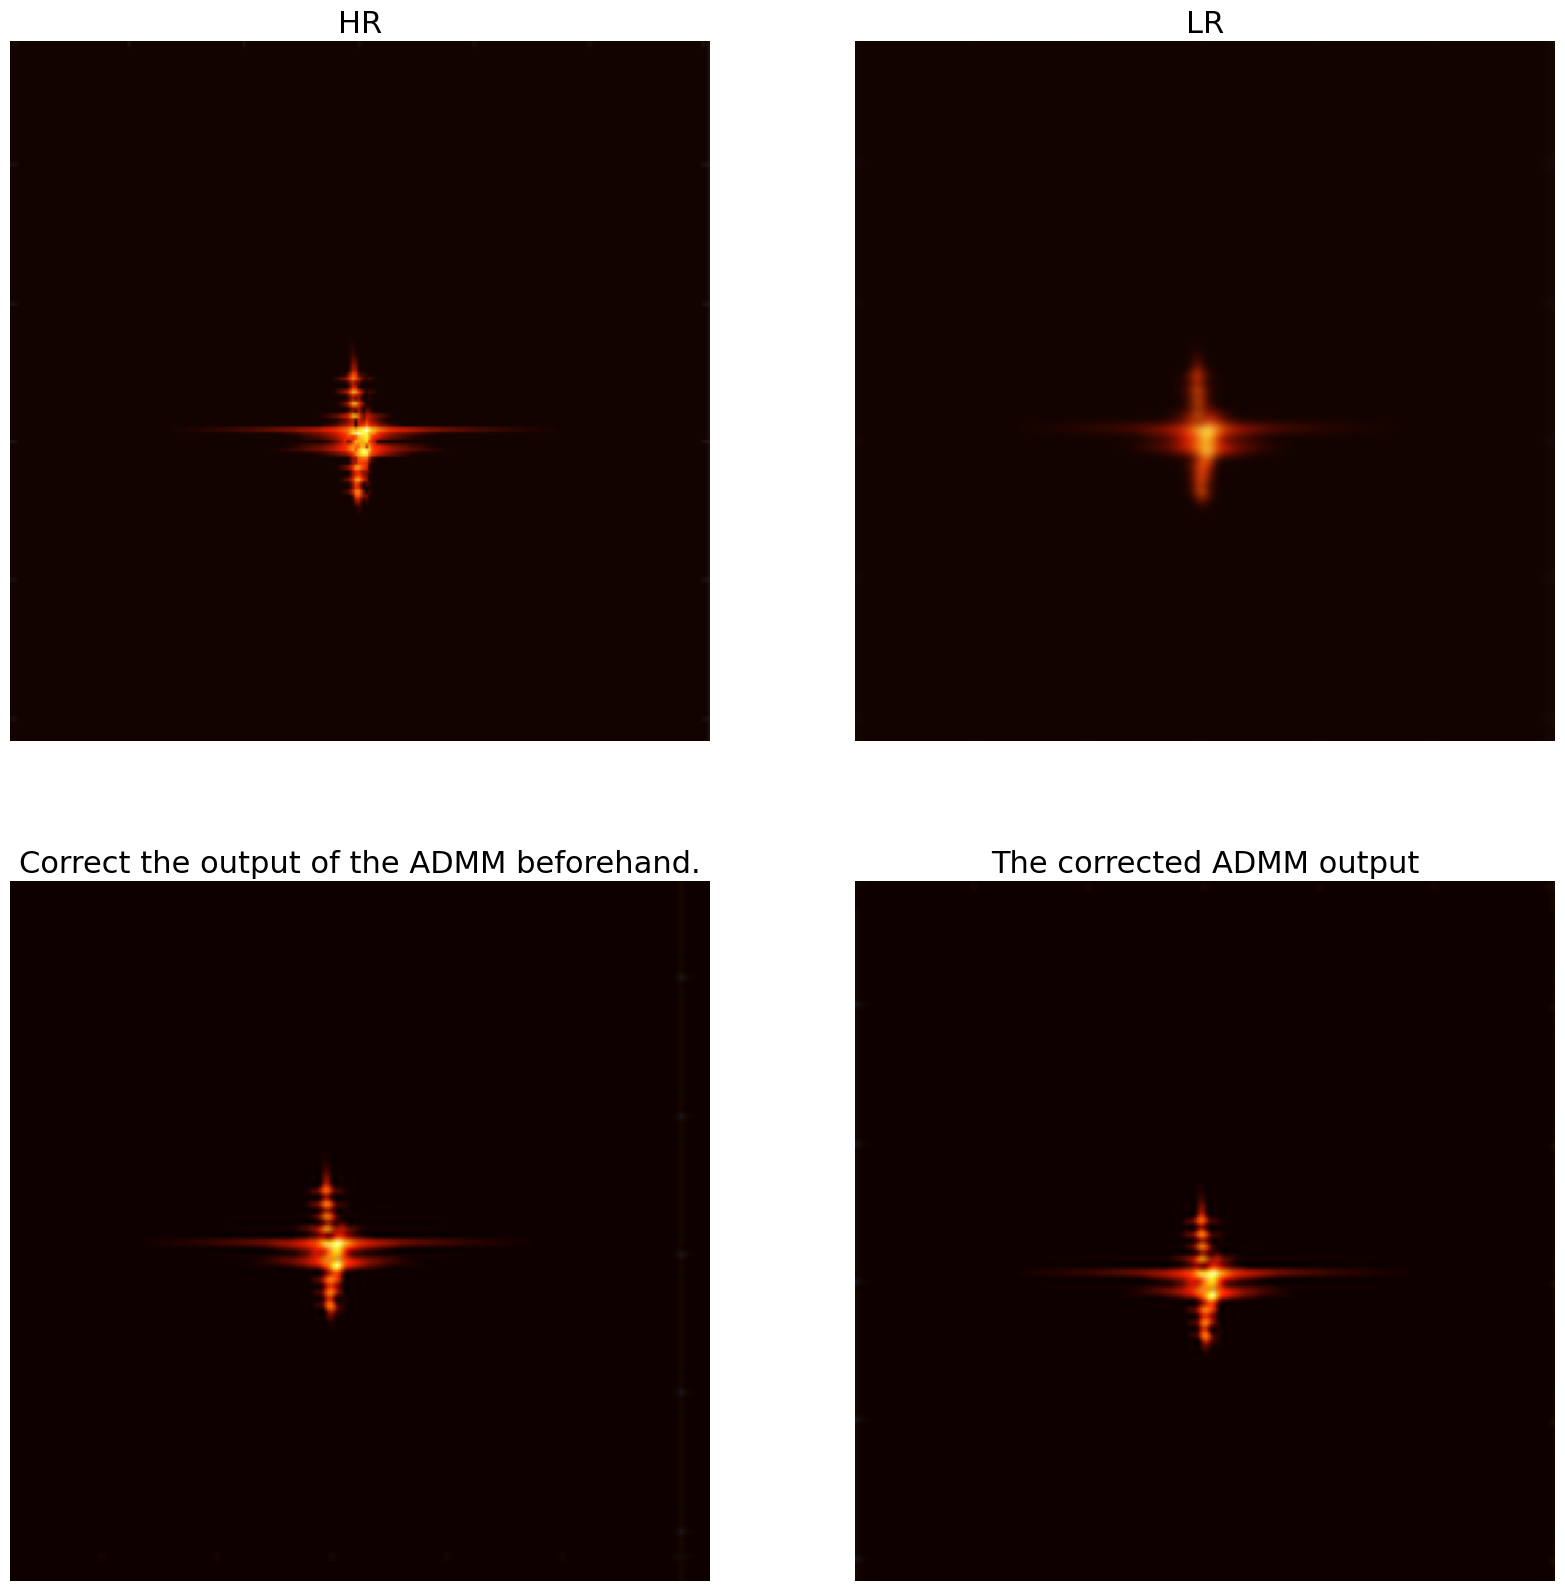

In [19]:
# 参数设置
lam = 0.01  # 正则化参数
rho = 1.0  # ADMM中的惩罚参数
num_iters = 1000  # 迭代次数
kernel2=kernel.detach().cpu().numpy().squeeze()
# 调用ADMM算法
X_rec = admm_convolution_RGB(RGB_blur, kernel2, lam, rho, num_iters,option="L1")
X_rec = np.transpose(X_rec.squeeze(),(1,2,0))
plt.imshow(X_rec)
plt.axis('off')  # 关闭坐标轴
plt.show()
#----------频域的求解存在边界误差，通过像素的移动进行手动修改-----
test1=X_rec[:245,:245,:]
test3=X_rec[245:256,:246,:]
test4=X_rec[:246,245:256,:]
test5=X_rec[246:256:,246:256,:]
test6= np.zeros_like(X_rec)
test6[0:11,10:256,:]=test3
test6[0:10,0:10,:]=test5
test6[10:256,0:11,:]=test4
test6[11:256,11:256,:]=test1
plt.imshow(test6)
plt.axis('off')  # 关闭坐标轴
plt.show()
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(np.transpose(HR_img.detach().cpu().numpy().squeeze(),(1,2,0)))
plt.axis('off')  # 关闭坐标轴
plt.title('HR', fontsize=22)  # 中文标注
plt.subplot(222)
plt.imshow(RGB_blur)
plt.axis('off')  # 关闭坐标轴
plt.title('LR', fontsize=22)  # 中文标注
plt.subplot(223)
plt.imshow(X_rec)
plt.axis('off')  # 关闭坐标轴
plt.title('Correct the output of the ADMM beforehand.', fontsize=22)  # 中文标注
plt.subplot(224)
plt.imshow(test6)
plt.axis('off')  # 关闭坐标轴
plt.title('The corrected ADMM output', fontsize=22)  # 中文标注
plt.show()
